In [1]:
%load_ext lab_black

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from traffic.data import airports
from traffic.core.geodesy import distance, greatcircle

In [5]:
airports_ = airports.data.query("iata.notnull()")[
    ["icao", "iata", "latitude", "longitude"]
]
routes = pd.read_csv("routes_raw.csv")
routes

,origin,destination,km
0,AAA,FAC,76
1,AAA,KXU,163
2,AAA,MKP,214
3,AAA,PPT,435
4,AAA,RRR,354
...,...,...,...
74532,ZYZ,AMS,126
74533,ZYZ,ZYR,31
74534,ZZU,CEH,100
74535,ZZU,LIX,106


In [6]:
for airport in ["origin", "destination"]:
    routes = (
        routes.merge(
            airports_,
            left_on=airport,
            right_on="iata",
            how="inner",
        )
        .drop(airport, axis=1)
        .rename(columns={"icao": f"{airport}_icao", "iata": f"{airport}_iata"})
    )

routes = routes[
    [
        "origin_iata",
        "destination_iata",
        "origin_icao",
        "destination_icao",
        "latitude_x",
        "longitude_x",
        "latitude_y",
        "longitude_y",
        "km",
    ]
].rename(
    columns={
        "latitude_x": "origin_lat",
        "latitude_y": "destination_lat",
        "longitude_x": "origin_lon",
        "longitude_y": "destination_lon",
    }
)
routes = (
    routes.assign(
        km_gc=np.round(
            distance(
                routes["origin_lat"],
                routes["origin_lon"],
                routes["destination_lat"],
                routes["destination_lon"],
            )
            / 1e3,
            1,
        )
    )
    .drop(["origin_lat", "origin_lon", "destination_lat", "destination_lon"], axis=1)
    .assign(
        # km_z=lambda x: np.abs(stats.zscore(x.km)),
        km_diff=lambda x: np.abs(x.km - x.km_gc),
        km_diff_z=lambda x: np.abs(stats.zscore(x.km_diff)),
    )
    .sort_values("km_diff")
    .drop_duplicates(["origin_iata", "destination_iata"])
)
routes[
    ["origin_iata", "destination_iata", "origin_icao", "destination_icao", "km"]
].to_csv("routes.csv", index=False)
routes

,origin_iata,destination_iata,origin_icao,destination_icao,km,km_gc,km_diff,km_diff_z
45716,AGR,HJR,VIAG,VAKJ,325,325.0,0.0,0.039965
42938,EZE,SLA,SAEZ,SASA,1292,1292.0,0.0,0.039965
71222,NEV,AXA,TKPN,TQPF,121,121.0,0.0,0.039965
71223,SBH,AXA,TFFJ,TQPF,40,40.0,0.0,0.039965
42817,AEP,PRA,SABE,SAAP,362,362.0,0.0,0.039965
...,...,...,...,...,...,...,...,...
72615,SAE,UMD,ID-SAE,BGUM,23,13051.6,13028.6,50.944932
72002,MGQ,GUO,HCMM,MHJI,375,14354.3,13979.3,54.665312
96,GUO,MGQ,MHJI,HCMM,375,14354.3,13979.3,54.665312
72001,GLK,GUO,HCMR,MHJI,229,14363.2,14134.2,55.271483


### Outliers

In [9]:
outlier_dist_diff = routes.query("km_diff_z>1").sort_values("km_diff", ascending=False)
print(len(outlier_dist_diff))
outlier_dist_diff

23


,origin_iata,destination_iata,origin_icao,destination_icao,km,km_gc,km_diff,km_diff_z
72113,GUO,AAD,MHJI,AAD,111,14313.8,14202.8,55.539936
72001,GLK,GUO,HCMR,MHJI,229,14363.2,14134.2,55.271483
96,GUO,MGQ,MHJI,HCMM,375,14354.3,13979.3,54.665312
72002,MGQ,GUO,HCMM,MHJI,375,14354.3,13979.3,54.665312
72615,SAE,UMD,ID-SAE,BGUM,23,13051.6,13028.6,50.944932
74055,UMD,SAE,BGUM,ID-SAE,23,13051.6,13028.6,50.944932
44354,KUZ,SGG,BGKM,WBGY,27,12148.1,12121.1,47.393607
44353,AGM,SGG,BGAM,WBGY,66,12187.1,12121.1,47.393607
72540,SGG,AGM,WBGY,BGAM,66,12187.1,12121.1,47.393607
74003,THR,AFN,OIII,KAFN,1942,9589.2,7647.2,29.885868


In [11]:
routes.loc[outlier_dist_diff.index, "km"] = routes.loc[outlier_dist_diff.index, "km_gc"]
routes.loc[outlier_dist_diff.index]

,origin_iata,destination_iata,origin_icao,destination_icao,km,km_gc,km_diff,km_diff_z
72113,GUO,AAD,MHJI,AAD,14313.8,14313.8,14202.8,55.539936
72001,GLK,GUO,HCMR,MHJI,14363.2,14363.2,14134.2,55.271483
96,GUO,MGQ,MHJI,HCMM,14354.3,14354.3,13979.3,54.665312
72002,MGQ,GUO,HCMM,MHJI,14354.3,14354.3,13979.3,54.665312
72615,SAE,UMD,ID-SAE,BGUM,13051.6,13051.6,13028.6,50.944932
74055,UMD,SAE,BGUM,ID-SAE,13051.6,13051.6,13028.6,50.944932
44354,KUZ,SGG,BGKM,WBGY,12148.1,12148.1,12121.1,47.393607
44353,AGM,SGG,BGAM,WBGY,12187.1,12187.1,12121.1,47.393607
72540,SGG,AGM,WBGY,BGAM,12187.1,12187.1,12121.1,47.393607
74003,THR,AFN,OIII,KAFN,9589.2,9589.2,7647.2,29.885868


In [12]:
routes[
    ["origin_iata", "destination_iata", "origin_icao", "destination_icao", "km"]
].to_csv("routes.csv", index=False)
len(routes)

### Distance

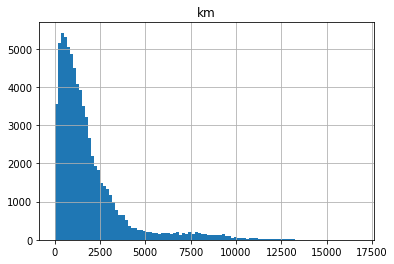

In [7]:
routes[["km"]].hist(bins=100)
plt.show()

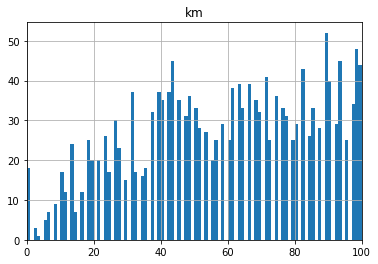

In [8]:
routes[["km"]].query("km<=100").hist(bins=100)
plt.xlim(0, 100)
plt.show()

In [13]:
routes = routes.drop(index=routes.query("km==0").index)
routes[
    ["origin_iata", "destination_iata", "origin_icao", "destination_icao", "km"]
].to_csv("routes.csv", index=False)
len(routes)

72971

In [28]:
fuel = pd.read_parquet("fuel1.parquet")
fuel

,typecode_oag,origin,destination,e_type,fuel_kgmin,fuel_kgmax,fuel_kgmean
71505,74F,HKG,ANC,Jet,3.200496e+08,3.200496e+08,3.200496e+08
37792,380,LHR,SIN,Jet,2.376824e+08,2.376824e+08,2.376824e+08
37852,380,SIN,LHR,Jet,2.375168e+08,2.375168e+08,2.375168e+08
71202,74F,ANC,HKG,Jet,2.275189e+08,2.275189e+08,2.275189e+08
71211,74F,ANC,ORD,Jet,1.973859e+08,1.973859e+08,1.973859e+08
...,...,...,...,...,...,...,...
91924,CNA,SVK,TZA,Piston,2.193285e+01,2.193285e+01,2.193285e+01
91362,CNA,LDZ,NGL,Piston,1.711680e+01,1.711680e+01,1.711680e+01
90666,CNA,ABL,OBU,Piston,1.699939e+01,1.699939e+01,1.699939e+01
92024,CNA,ULX,NGL,Piston,1.641236e+01,1.641236e+01,1.641236e+01


In [97]:
fuel.merge(
    outlier_dist_diff,
    left_on=["origin", "destination"],
    right_on=["origin_icao", "destination_icao"],
).sort_values("km_diff", ascending=False)

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


,"(typecode_oag, )","(origin, )","(destination, )","(e_type, )","(fuel_kg, min)","(fuel_kg, max)","(fuel_kg, mean)",origin_iata,destination_iata,origin_icao,destination_icao,km,km_gc,km_z,km_diff,km_diff_z
29,F50,MHJI,AAD,Turboprop,1.432931e+04,1.432931e+04,1.432931e+04,GUO,AAD,MHJI,AAD,111,14313.8,0.891794,14202.8,57.321600
26,F50,HCMR,MHJI,Turboprop,2.413590e+04,2.413590e+04,2.413590e+04,GLK,GUO,HCMR,MHJI,229,14363.2,0.831752,14134.2,57.044546
24,F50,HCMM,MHJI,Turboprop,7.247139e+04,7.247139e+04,7.247139e+04,MGQ,GUO,HCMM,MHJI,375,14354.3,0.757462,13979.3,56.418955
25,F50,MHJI,HCMM,Turboprop,7.247139e+04,7.247139e+04,7.247139e+04,GUO,MGQ,MHJI,HCMM,375,14354.3,0.757462,13979.3,56.418955
6,32S,VTBS,KU42,Jet,3.402249e+06,4.539059e+06,3.800395e+06,BKK,UTH,VTBS,KU42,465,13115.0,0.711667,12650.0,51.050338
7,32S,KU42,VTBS,Jet,3.400023e+06,4.536088e+06,3.797908e+06,UTH,BKK,KU42,VTBS,465,13115.0,0.711667,12650.0,51.050338
0,737,VTBD,KU42,Jet,7.441749e+06,9.761259e+06,8.823572e+06,DMK,UTH,VTBD,KU42,451,13099.3,0.718791,12648.3,51.043472
1,32S,VTBD,KU42,Jet,4.227753e+06,5.618489e+06,4.718540e+06,DMK,UTH,VTBD,KU42,451,13099.3,0.718791,12648.3,51.043472
2,DH8,VTBD,KU42,Turboprop,2.542576e+03,4.237340e+03,3.026810e+03,DMK,UTH,VTBD,KU42,451,13099.3,0.718791,12648.3,51.043472
3,737,KU42,VTBD,Jet,7.441749e+06,9.761259e+06,8.823572e+06,UTH,DMK,KU42,VTBD,451,13099.3,0.718791,12648.3,51.043472


In [98]:
fuel.merge(
    outlier_dist_diff,
    left_on=["origin", "destination"],
    right_on=["origin_icao", "destination_icao"],
).fuel_kg


/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


AttributeError: 'DataFrame' object has no attribute 'fuel_kg'